<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Aplicando Inteligência Artificial para fazer previsões</font></b></strong>

O que acha de trazer Inteligência Artificial para nossa conversa?

De todos os modelos que criamos até aqui no curso, nenhum deles pode ser considerado Inteligência Artificial, mas a partir de agora usaremos Deep Learning, atualmente a principalmente técnica de IA e o estado de arte para a solução de diversos problemas, incluindo previsões de séries temporais. 

**Deep Learning - Modelo LSTM**

Os problemas de previsão de séries temporais são um tipo difícil de problema de modelagem preditiva. As séries temporais adicionam a complexidade de uma dependência de sequência entre as variáveis de entrada.

Um tipo poderoso de rede neural projetada para lidar com a dependência de sequência é chamado de Rede Neural Recorrente. A rede Long Short-Term Memory ou LSTM é um tipo de rede neural recorrente usada em aprendizado profundo que apresenta bons resultados, quando devidamente treinada.

Esta e as próximas aulas consideram que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.

Vamos ao trabalho.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels      0.11.1
statsmodels.api  0.11.1
seaborn          0.10.1
tensorflow       1.10.0
pandas           1.0.5
matplotlib       3.2.2
numpy            1.16.6
sklearn          0.23.1
tensorflow.keras 2.1.6-tf
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [5]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [6]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [8]:
# Random seed 
np.random.seed(7)

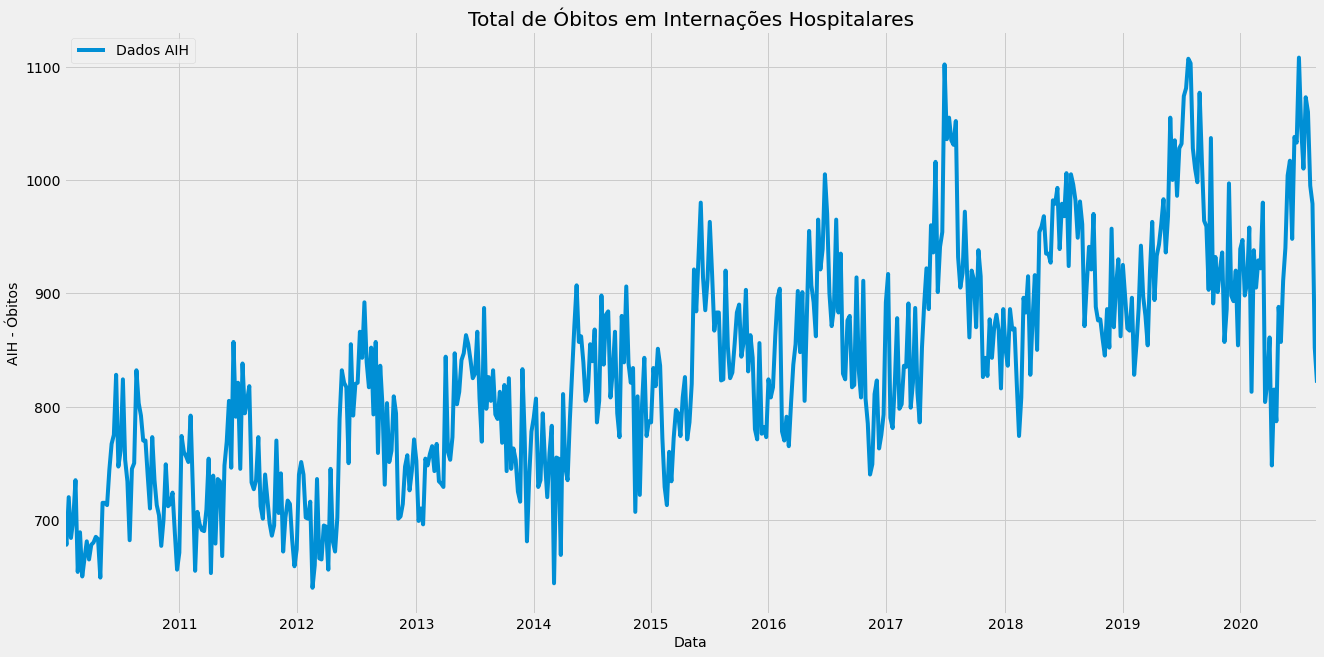

In [9]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [11]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [12]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM possuem blocos de memória conectados através de camadas.

Um bloco possui componentes que o tornam mais inteligente que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera sobre uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se são acionadas ou não, condicionando a mudança de estado e a adição de informações que fluem através do bloco.

Existem três tipos de portas dentro de uma unidade:

- Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
- Input Gate: decide condicionalmente quais valores da entrada atualizar o estado da memória.
- Output Gate: decide condicionalmente o que enviar com base na entrada e na memória do bloco.

Cada unidade é como uma máquina de mini estado onde os portões das unidades têm pesos que são aprendidos durante o procedimento de treinamento.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [13]:
# Cria o scaler para dimensionar nossos dados entre 0 e 1
scaler = MinMaxScaler()

In [14]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [15]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

Aqui definimos os hiperparâmetros.

In [16]:
# Número de repetições
n_rep = 5

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 24 séries para prever as 24 séries seguintes)
n_input = 139

# Comprimento das sequências de saída (em número de timesteps)
n_output = 139
# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [17]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.

Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de neurônios e dropout). Por agora, leia os comentários em cada linha de código abaixo.

In [18]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    modelo_lstm.add(LSTM(50, activation = 'relu', input_shape = (n_input, n_features)))
    
    # A camada de Dropout aplica regularização à rede, removendo alguns neurônios e evitando overfitting
    modelo_lstm.add(Dropout(0.10))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
28/28 [==============================] - 20s 721ms/step - loss: 0.0511
Epoch 2/200
28/28 [==============================] - 11s 383ms/step - loss: 0.0175
Epoch 3/200
28/28 [==============================] - 11s 384ms/step - loss: 0.0152
Epoch 4/200
28/28 [==============================] - 11s 388ms/step - loss: 0.0142
Epoch 5/200
28/28 [==============================] - 11s 384ms/step - loss: 0.0127
Epoch 6/200
28/28 [==============================] - 11s 390ms/step - loss: 0.0116
Epoch 7/200
28/28 [==============================] - 12s 440ms/step - loss: 0.0117
Epoch 8/200
28/28 [==============================] - 13s 447ms/step - loss: 0.0121
Epoch 9/200
28/28 [==============================] - 12s 443ms/step - loss: 0.0119
Epoch 10/200
28/28 [==============================] - 12s 411ms/step - loss: 0.0110
Epoch 11/200
28/28 [==============================] - 13s 449ms/step - loss: 0.0113
Epoch 12/200
28/28 [==============================] - 13s 449ms/step - loss: 0.0136
E

28/28 [==============================] - 12s 444ms/step - loss: 0.0097
Epoch 195/200
28/28 [==============================] - 13s 449ms/step - loss: 0.0094
Epoch 196/200
28/28 [==============================] - 13s 447ms/step - loss: 0.0090
Epoch 197/200
28/28 [==============================] - 12s 445ms/step - loss: 0.0091
Epoch 198/200
28/28 [==============================] - 12s 446ms/step - loss: 0.0091
Epoch 199/200
28/28 [==============================] - 12s 446ms/step - loss: 0.0091
Epoch 200/200
28/28 [==============================] - 13s 469ms/step - loss: 0.0092
Epoch 1/200
28/28 [==============================] - 15s 549ms/step - loss: 0.0587
Epoch 2/200
28/28 [==============================] - 13s 455ms/step - loss: 0.0138
Epoch 3/200
28/28 [==============================] - 13s 448ms/step - loss: 0.0150
Epoch 4/200
28/28 [==============================] - 13s 448ms/step - loss: 0.0131
Epoch 5/200
28/28 [==============================] - 13s 450ms/step - loss: 0.0136
Epoc

28/28 [==============================] - 15s 523ms/step - loss: 0.0101
Epoch 188/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0105
Epoch 189/200
28/28 [==============================] - 14s 515ms/step - loss: 0.0104
Epoch 190/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0097
Epoch 191/200
28/28 [==============================] - 15s 523ms/step - loss: 0.0100
Epoch 192/200
28/28 [==============================] - 15s 527ms/step - loss: 0.0102
Epoch 193/200
28/28 [==============================] - 14s 507ms/step - loss: 0.0100
Epoch 194/200
28/28 [==============================] - 14s 512ms/step - loss: 0.0099
Epoch 195/200
28/28 [==============================] - 14s 510ms/step - loss: 0.0103
Epoch 196/200
28/28 [==============================] - 14s 510ms/step - loss: 0.0100
Epoch 197/200
28/28 [==============================] - 14s 512ms/step - loss: 0.0099
Epoch 198/200
28/28 [==============================] - 14s 513ms/step - loss: 0

28/28 [==============================] - 14s 514ms/step - loss: 0.0095
Epoch 181/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0103
Epoch 182/200
28/28 [==============================] - 14s 508ms/step - loss: 0.0097
Epoch 183/200
28/28 [==============================] - 14s 506ms/step - loss: 0.0099
Epoch 184/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0092
Epoch 185/200
28/28 [==============================] - 14s 512ms/step - loss: 0.0097
Epoch 186/200
28/28 [==============================] - 14s 516ms/step - loss: 0.0106
Epoch 187/200
28/28 [==============================] - 14s 509ms/step - loss: 0.0100
Epoch 188/200
28/28 [==============================] - 15s 521ms/step - loss: 0.0099
Epoch 189/200
28/28 [==============================] - 14s 507ms/step - loss: 0.0096
Epoch 190/200
28/28 [==============================] - 14s 516ms/step - loss: 0.0097
Epoch 191/200
28/28 [==============================] - 14s 517ms/step - loss: 0

28/28 [==============================] - 14s 490ms/step - loss: 0.0116
Epoch 174/200
28/28 [==============================] - 13s 453ms/step - loss: 0.0112
Epoch 175/200
28/28 [==============================] - 13s 452ms/step - loss: 0.0111
Epoch 176/200
28/28 [==============================] - 13s 451ms/step - loss: 0.0102
Epoch 177/200
28/28 [==============================] - 13s 452ms/step - loss: 0.0094
Epoch 178/200
28/28 [==============================] - 13s 447ms/step - loss: 0.0090
Epoch 179/200
28/28 [==============================] - 13s 461ms/step - loss: 0.0097
Epoch 180/200
28/28 [==============================] - 13s 453ms/step - loss: 0.0104
Epoch 181/200
28/28 [==============================] - 13s 456ms/step - loss: 0.0097
Epoch 182/200
28/28 [==============================] - 13s 460ms/step - loss: 0.0096
Epoch 183/200
28/28 [==============================] - 13s 465ms/step - loss: 0.0094
Epoch 184/200
28/28 [==============================] - 13s 451ms/step - loss: 0

28/28 [==============================] - 14s 507ms/step - loss: 0.0095
Epoch 167/200
28/28 [==============================] - 14s 508ms/step - loss: 0.0098
Epoch 168/200
28/28 [==============================] - 14s 512ms/step - loss: 0.0097
Epoch 169/200
28/28 [==============================] - 14s 505ms/step - loss: 0.0101
Epoch 170/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0095
Epoch 171/200
28/28 [==============================] - 14s 514ms/step - loss: 0.0095
Epoch 172/200
28/28 [==============================] - 14s 511ms/step - loss: 0.0094
Epoch 173/200
28/28 [==============================] - 14s 509ms/step - loss: 0.0101
Epoch 174/200
28/28 [==============================] - 14s 509ms/step - loss: 0.0098
Epoch 175/200
28/28 [==============================] - 14s 506ms/step - loss: 0.0095
Epoch 176/200
28/28 [==============================] - 14s 510ms/step - loss: 0.0102
Epoch 177/200
28/28 [==============================] - 14s 505ms/step - loss: 0

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 139 sequências para prever 139 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (20)
- timesteps = n_input (139)
- features = n_features (1)

Agora calculamos o erro modelo.

In [19]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [20]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [21]:
# Previsões finais
resultado_final

array([[840.03053701],
       [838.19591366],
       [836.09573116],
       [834.13708512],
       [832.33461988],
       [830.72718239],
       [829.36456016],
       [828.23562261],
       [827.38895662],
       [826.96143382],
       [826.73224599],
       [826.82360389],
       [826.90728163],
       [827.21142886],
       [827.73696533],
       [828.38229477],
       [829.07698491],
       [830.04192655],
       [831.37023724],
       [833.09214473],
       [835.13128519],
       [837.39176809],
       [839.81963398],
       [842.39512484],
       [845.16632361],
       [848.21100403],
       [851.57391152],
       [855.26718456],
       [859.23631708],
       [863.23508117],
       [867.08744158],
       [870.47331659],
       [873.03495892],
       [874.41252841],
       [874.28251772],
       [872.09235832],
       [867.26081533],
       [859.74257466],
       [853.18485039],
       [847.63011886],
       [842.98154639],
       [839.33440254],
       [836.37733357],
       [833

In [22]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((139,))

In [23]:
# Previsões finais
resultado_final

array([840.03053701, 838.19591366, 836.09573116, 834.13708512,
       832.33461988, 830.72718239, 829.36456016, 828.23562261,
       827.38895662, 826.96143382, 826.73224599, 826.82360389,
       826.90728163, 827.21142886, 827.73696533, 828.38229477,
       829.07698491, 830.04192655, 831.37023724, 833.09214473,
       835.13128519, 837.39176809, 839.81963398, 842.39512484,
       845.16632361, 848.21100403, 851.57391152, 855.26718456,
       859.23631708, 863.23508117, 867.08744158, 870.47331659,
       873.03495892, 874.41252841, 874.28251772, 872.09235832,
       867.26081533, 859.74257466, 853.18485039, 847.63011886,
       842.98154639, 839.33440254, 836.37733357, 833.81892551,
       831.68887325, 829.94271087, 828.40230341, 827.02487986,
       825.78922545, 824.6570261 , 823.61404362, 822.66186966,
       821.76591045, 821.02550557, 820.33140198, 819.67616736,
       818.95821092, 818.28365059, 817.9611924 , 817.83192521,
       817.88223732, 818.16491368, 818.63951158, 819.31

In [24]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 14432.3218
RMSE das previsões é 120.1346
MAPE das previsões é 10.2775


Nossa rede não apresentou um resultado magnífico, mas não foi ruim. Está no mesmo nível de um modelo SARIMAX 
A diferença é que ainda temos muitas opções de otimização do Modelo LSTM.
Abaixo o plot das previsões.

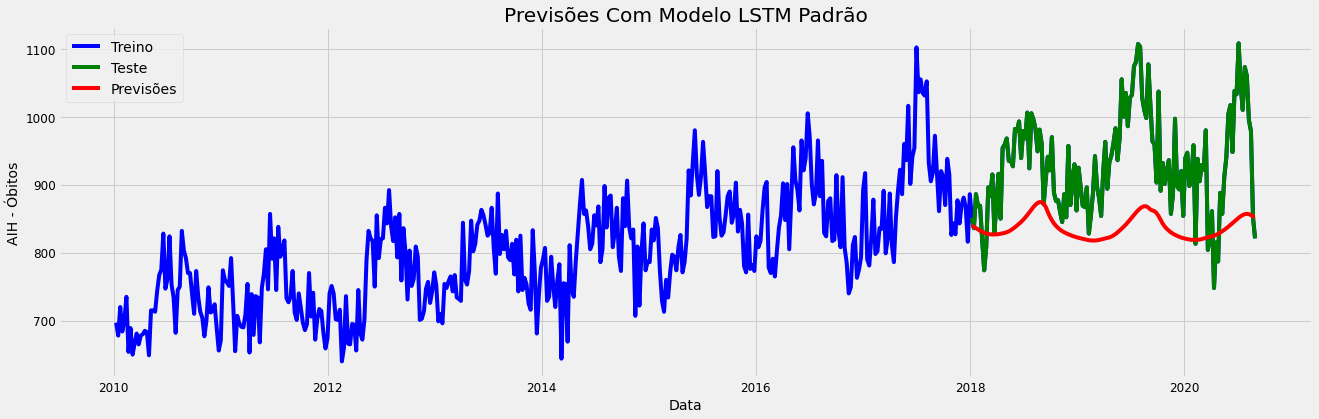

In [25]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(target[417:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

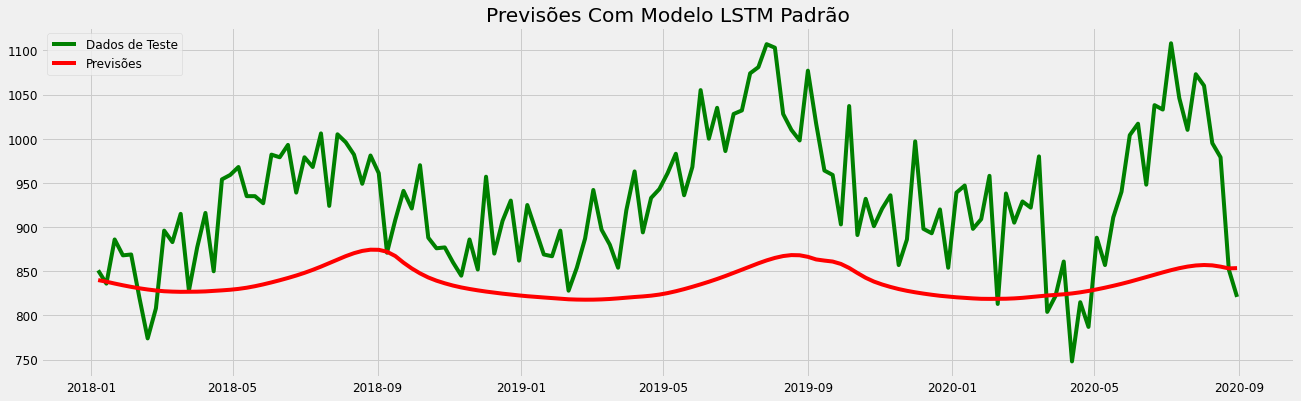

In [26]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[417:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Padrão')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [27]:
# Última data da série
target.index[-1]

Timestamp('2020-08-30 00:00:00', freq='W-SUN')

In [28]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(weeks = x) for x in range(0, 140)]

In [29]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [30]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [31]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [32]:
# Visualiza os dados
#df_original.head()

In [33]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [34]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [35]:
# Concatenamos a série original com os valores de forecasting de 139 semanas além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [36]:
# Visualiza o dataframe
df_forecasting

,QT_INTER,Prediction
2010-01-10,697.0,NaN
2010-01-17,678.0,NaN
2010-01-24,720.0,NaN
2010-01-31,684.0,NaN
2010-02-07,700.0,NaN
...,...,...
2023-04-02,NaN,902.210910
2023-04-09,NaN,914.250045
2023-04-16,NaN,927.251335
2023-04-23,NaN,940.780819


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de validação, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

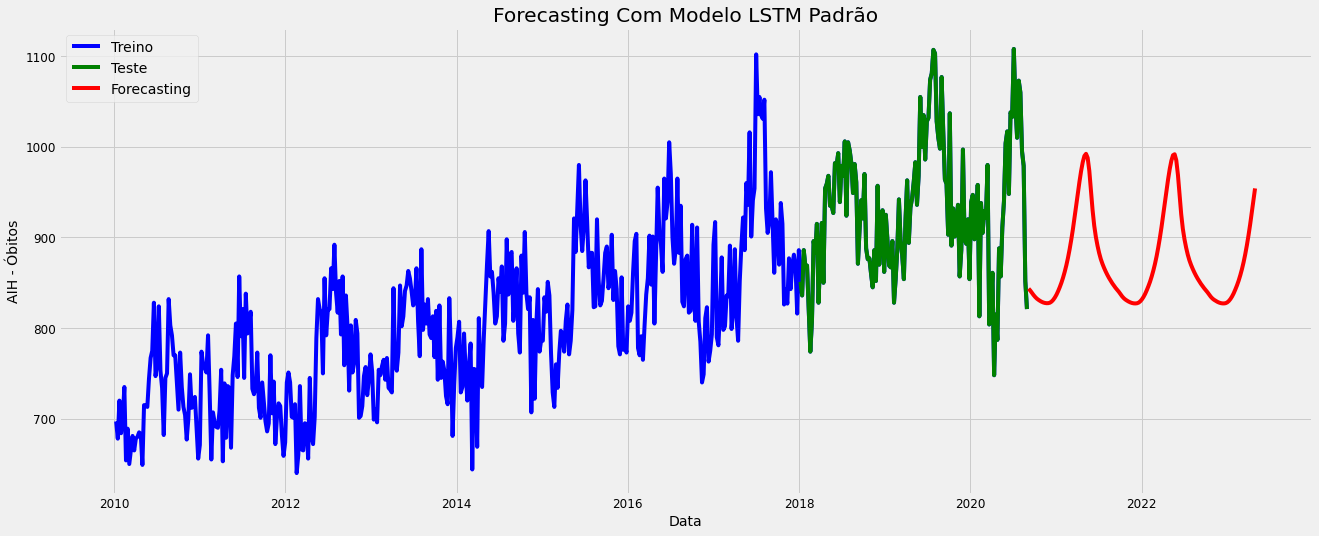

In [37]:
# Plot
plt.figure(figsize = (20, 8))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'],
         label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (4,5) - AIC = 38735.11 e RMSE = 236.8709
- Modelo 16 --> Modelo ARIMA Forcast (5,1,2) - AIC = 39559.670 e RMSE = 459.1013
- Modelo 17 --> Modelo SARIMA (2, 1, 2)x(2, 1, 0, 12) - AIC = 4104.139 e RMSE = 197.0291
- Modelo 18 --> Modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) - AIC = 4131.634 e RMSE = 81.8482
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.3762 e RMSE = 130.1589   -   (3 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.2775 e RMSE = 120.1346   -   (5 repetições)

Nosso modelo de Deep Learning veio para a briga como um candidato de peso. Nas próximas aulas vamos otimizar o modelo e trabalhar com diferentes arquiteturas LSTM.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim